In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from scipy import stats
from skbio import DistanceMatrix
import qiime2
from biom import Table
from qiime2 import Artifact
import os
from biom.util import biom_open
from qiime2.plugins import (feature_table,
fragment_insertion, 
feature_classifier, 
diversity, 
metadata, 
emperor, 
deicode, 
gneiss, 
taxa)
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from perm_test import perm_kruskal_test  ##jamie morton script from sal quant paper
from statsmodels.stats.multitest import multipletests
%matplotlib inline

In [2]:
#load metadata
md = qiime2.Metadata.load('filtered-metadata.qza').to_dataframe()
md.loc[(md.sample_storage_temp_treatment == '20C') & (md.sample_preservation_method == 'no_preservative'), 'sample_storage_temp_treatment'] = '20C no preservative'
md.to_csv('adjusted_meta.tsv', sep='\t')
meta_file = 'adjusted_meta.tsv'
# mappin = pd.read_csv('49476_49476_analysis_mapping.txt', sep='\t')
# data.loc[~data['sample_name'].isin(mappin['#SampleID']),'sample_name'] = data.loc[~data['sample_name'].isin(mappin['#SampleID']),'sample_name'].map(lambda n: n.replace('141804.', '142134.'))
# # data = data.loc[data['sample_preservation_method'] != 'not applicable']
# data
# data.to_csv('metadata.txt', index=False, sep='\t')
meta = qiime2.Metadata.load(meta_file)

### Import deblur feature table

In [3]:
tbl = Artifact.load('tree-filtered-table.qza')

# Singletons out
tbl_freq2 = feature_table.actions.filter_features(tbl, min_frequency = 2)

# Doubletons out
tbl_freq3 = feature_table.actions.filter_features(tbl, min_frequency = 3)
# tbl = tbl_freq3.filtered_table

# 10-tons
tbl_freq10 = feature_table.actions.filter_features(tbl, min_frequency = 10)

tbl_freq2.filtered_table.save('output/142185_feature-table_freq2.qza')
tbl_freq3.filtered_table.save('output/142185_feature-table_freq3.qza')
tbl_freq10.filtered_table.save('output/142185_feature-table_freq10.qza')

'output/142185_feature-table_freq10.qza'

In [4]:
meta.to_dataframe()['sample_storage_temp_treatment'].unique()

array(['heat', 'amb', '4C', '20C no preservative', 'freezethaw', '20C'],
      dtype=object)

/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/q2_feature_table/_summarize/_visualizer.py:122: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  os.path.join(output_dir, 'sample-frequency-detail.csv'))
/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/q2_feature_table/_summarize/_visualizer.py:124: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  os.path.join(output_dir, 'feature-frequency-detail.csv'))


<visualization: Visualization uuid: 83644a60-63f0-45eb-b203-153d3d9e4bc0>

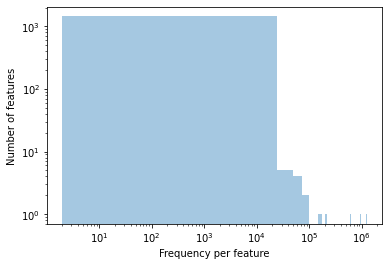

In [5]:
feature_table.visualizers.summarize(tbl_freq2.filtered_table, meta).visualization

In [6]:
# feature_table.visualizers.summarize(tbl_freq3.filtered_table, meta).visualization

In [7]:
# feature_table.visualizers.summarize(tbl_freq10.filtered_table, meta).visualization

### Alpha diversity mertics

In [8]:
# add read counts to metadata
sq_df = pd.DataFrame(tbl.view(Table).sum('sample'),tbl.view(Table).ids(),['sequencing_depth'])
sq_df_all = pd.concat([sq_df, meta.to_dataframe()], axis= 1)
sq_df_all.index.name = 'sampleid'
meta_sq = qiime2.Metadata(sq_df_all)

# import tree
tree = Artifact.import_data('Phylogeny[Rooted]', 'tree.nwk')

/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/q2_feature_table/_summarize/_visualizer.py:122: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  os.path.join(output_dir, 'sample-frequency-detail.csv'))
/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/q2_feature_table/_summarize/_visualizer.py:124: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  os.path.join(output_dir, 'feature-frequency-detail.csv'))


<visualization: Visualization uuid: 2db00f8b-8b6d-4af7-8ef6-8ed82a2114ad>

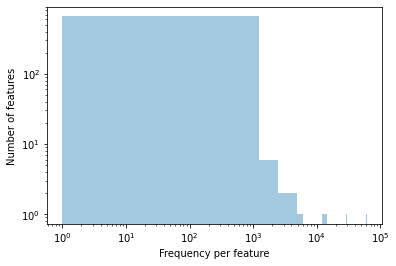

In [6]:
sam_depth = 986
rare_tbl = feature_table.actions.rarefy(tbl, sam_depth)
rare_tbl2 = feature_table.actions.rarefy(tbl_freq2.filtered_table, sam_depth)
rare_tbl3 = feature_table.actions.rarefy(tbl_freq3.filtered_table, sam_depth)
rare_tbl10 = feature_table.actions.rarefy(tbl_freq10.filtered_table, sam_depth)
rare_tbl.rarefied_table.save('output/rare_feature-table.qza')
feature_table.visualizers.summarize(rare_tbl.rarefied_table, meta).visualization

In [16]:
# rare_tbl=tbl_freq2.filtered_table
core_metr_phyl = diversity.pipelines.core_metrics_phylogenetic(table=rare_tbl.rarefied_table,
# core_metr_phyl = diversity.pipelines.core_metrics_phylogenetic(table=rare_tbl,
                                                          phylogeny = tree,
                                                          sampling_depth = sam_depth,
                                                          metadata = meta_sq,
                                                          n_jobs_or_threads = 4)
# core_metr_phyl_2 = diversity.pipelines.core_metrics_phylogenetic(table=rare_tbl2.rarefied_table,
#                                                           phylogeny = tree,
#                                                           sampling_depth = sam_depth,
#                                                           metadata = meta_sq,
#                                                           n_jobs_or_threads = 4)

# core_metr_phyl_3 = diversity.pipelines.core_metrics_phylogenetic(table=rare_tbl3.rarefied_table,
#                                                           phylogeny = tree,
#                                                           sampling_depth = sam_depth,
#                                                           metadata = meta_sq,
#                                                           n_jobs_or_threads = 4)

# core_metr_phyl_10 = diversity.pipelines.core_metrics_phylogenetic(table=rare_tbl10.rarefied_table,
#                                                           phylogeny = tree,
#                                                           sampling_depth = sam_depth,
#                                                           metadata = meta_sq,
#                                                           n_jobs_or_threads = 4)

/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.06935691904547842 and the largest is 8.704967247835569.
  RuntimeWarning
/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitu

In [64]:
# core_metr_phyl.weighted_unifrac_emperor.save('Data/150bp_deblur_ref_hit_tbl/bdiv/emperor/weighted_unifrac_minfreq10.pcoa.qzv')

In [65]:
meta_df = meta.to_dataframe()

#run an alpha diversity metric
alpha_diversity = core_metr_phyl.observed_features_vector
alp = alpha_diversity.view(pd.Series)
alp = alp.to_frame()
alp.columns = ['obs_feat']
#add it in!
meta_df = pd.merge(meta_df, alp, right_index=True, left_index=True, how='right')

#run an alpha diversity metric
alpha_diversity = core_metr_phyl.faith_pd_vector
alp = alpha_diversity.view(pd.Series)
alp = alp.to_frame()
alp.columns = ['faith_pd']
#add it in!
meta_df = pd.merge(meta_df, alp, right_index=True, left_index=True, how='right')

#run an alpha diversity metric
alpha_diversity = core_metr_phyl.evenness_vector
alp = alpha_diversity.view(pd.Series)
alp = alp.to_frame()
alp.columns = ['evenness']
#add it in!
meta_df = pd.merge(meta_df, alp, right_index=True, left_index=True, how='right')

#run an alpha diversity metric
alpha_diversity = core_metr_phyl.shannon_vector
alp = alpha_diversity.view(pd.Series)
alp = alp.to_frame()
alp.columns = ['shannon']
#add it in!
meta_df = pd.merge(meta_df, alp, right_index=True, left_index=True, how='right')
meta_df

,collection_timestamp,description,dna_extracted,elevation,empo_1,empo_2,empo_3,env_biome,env_feature,env_material,...,specimen_id,taxon_id,technical_replicate_number,title,tube_id,vaginal_subject_id,obs_feat,faith_pd,evenness,shannon
14383.A.none.20C.urine.2,12/28/21,Urine sample obtained through Peezy collection...,TRUE,193.0,Host-associated,Animal,Animal secretion,urban biome,human-associated habitat,urine,...,A.none.20C.urine,2516875.0,2.0,Effects of Assay Assure preservative on urine ...,A.none.20C.urine.2,not applicable,11,3.727162,0.063120,0.218359
14383.A.AssayAssure.freezethaw.urine.1,12/28/21,Urine sample obtained through Peezy collection...,TRUE,193.0,Host-associated,Animal,Animal secretion,urban biome,human-associated habitat,urine,...,A.AssayAssure.freezethaw.urine,2516875.0,1.0,Effects of Assay Assure preservative on urine ...,A.AssayAssure.freezethaw.urine.1,not applicable,21,4.793366,0.181353,0.796560
14383.B.AssayAssure.heat.urine.3,12/28/21,Urine sample obtained through Peezy collection...,TRUE,193.0,Host-associated,Animal,Animal secretion,urban biome,human-associated habitat,urine,...,B.AssayAssure.heat.urine,2516875.0,3.0,Effects of Assay Assure preservative on urine ...,B.AssayAssure.heat.urine.3,not applicable,24,4.829931,0.367165,1.683438
14383.B.AssayAssure.amb.urine.1,12/28/21,Urine sample obtained through Peezy collection...,TRUE,193.0,Host-associated,Animal,Animal secretion,urban biome,human-associated habitat,urine,...,B.AssayAssure.amb.urine,2516875.0,1.0,Effects of Assay Assure preservative on urine ...,B.AssayAssure.amb.urine.1,not applicable,42,8.245571,0.425222,2.292930
14383.A.AssayAssure.20C.urine.1,12/28/21,Urine sample obtained through Peezy collection...,TRUE,193.0,Host-associated,Animal,Animal secretion,urban biome,human-associated habitat,urine,...,A.AssayAssure.20C.urine,2516875.0,1.0,Effects of Assay Assure preservative on urine ...,A.AssayAssure.20C.urine.1,not applicable,24,5.415292,0.120630,0.553082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14383.I.AssayAssure.amb.urine.2,12/28/21,Urine sample obtained through Peezy collection...,TRUE,193.0,Host-associated,Animal,Animal secretion,urban biome,human-associated habitat,urine,...,I.AssayAssure.amb.urine,2516875.0,2.0,Effects of Assay Assure preservative on urine ...,I.AssayAssure.amb.urine.2,not applicable,6,1.857745,0.018623,0.048139
14383.E.AssayAssure.heat.urine.2,12/28/21,Urine sample obtained through Peezy collection...,TRUE,193.0,Host-associated,Animal,Animal secretion,urban biome,human-associated habitat,urine,...,E.AssayAssure.heat.urine,2516875.0,2.0,Effects of Assay Assure preservative on urine ...,E.AssayAssure.heat.urine.2,not applicable,42,7.907518,0.465786,2.511668
14383.I.AssayAssure.heat.urine.3,12/28/21,Urine sample obtained through Peezy collection...,TRUE,193.0,Host-associated,Animal,Animal secretion,urban biome,human-associated habitat,urine,...,I.AssayAssure.heat.urine,2516875.0,3.0,Effects of Assay Assure preservative on urine ...,I.AssayAssure.heat.urine.3,not applicable,4,1.413161,0.011929,0.023858
14383.I.AssayAssure.amb.urine.1,12/28/21,Urine sample obtained through Peezy collection...,TRUE,193.0,Host-associated,Animal,Animal secretion,urban biome,human-associated habitat,urine,...,I.AssayAssure.amb.urine,2516875.0,1.0,Effects of Assay Assure preservative on urine ...,I.AssayAssure.amb.urine.1,not applicable,5,1.319098,0.024626,0.057180


### plotting alpha diversity (Change order)

No handles with labels found to put in legend.


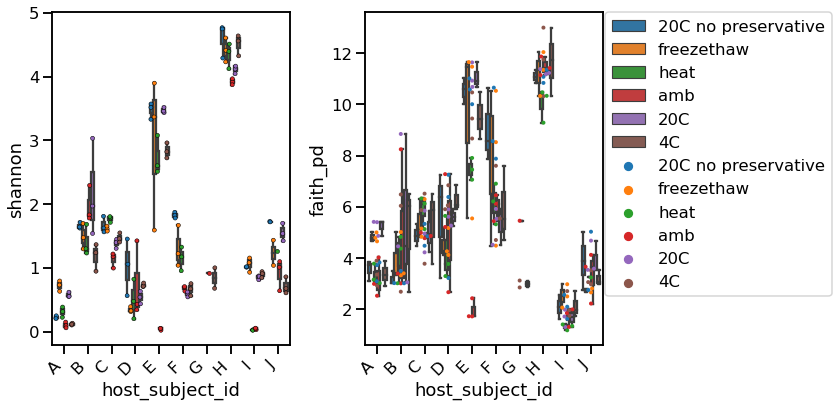

In [66]:
order=['A', 'B', 'C','D','E','F','G','H','I','J']
subject_id = 'host_subject_id'
variable_1='sample_storage_temp_treatment'
variable_2='sample_preservation_method'

fig, (ax, ax2) = plt.subplots(1,2,figsize=(12,6))
meta_df_assay = meta_df#.loc[meta_df['sample_preservation_method'] == 'assay_assure']
sns.boxplot(x=subject_id, y='shannon', 
            data=meta_df_assay, ax=ax, hue=variable_1, 
            order=order)
sns.stripplot(x=subject_id, y='shannon', 
              dodge= True, data=meta_df_assay, ax=ax, 
              hue=variable_1, size=4, linewidth=0.5, edgecolor='black',
              order=order)
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
ax.get_legend().remove() # remove legend
sns.boxplot(x=subject_id, y='faith_pd', data=meta_df_assay, ax=ax2, hue=variable_1, order=order)
sns.swarmplot(x=subject_id, y='faith_pd', data=meta_df_assay, ax=ax2, hue=variable_1, size=4, order=order)
sns.set_context('talk')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.tight_layout()

No handles with labels found to put in legend.


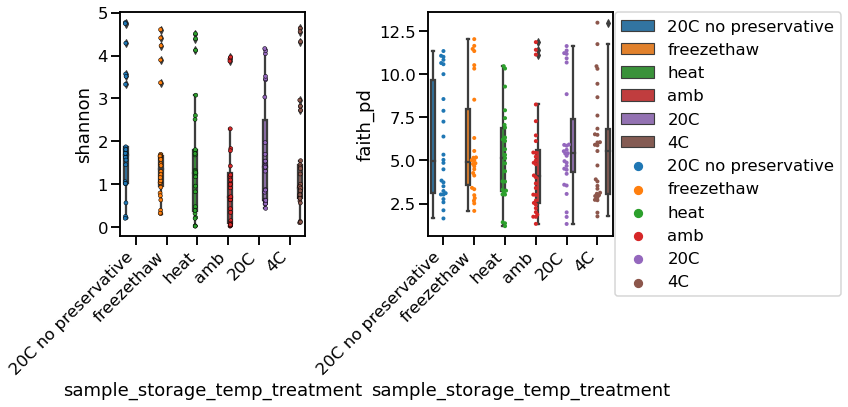

In [67]:
order=['A', 'B', 'C','D','E','F','G','H','I','J']
subject_id = 'host_subject_id'
variable_1='sample_storage_temp_treatment'
variable_2='sample_preservation_method'

fig, (ax, ax2) = plt.subplots(1,2,figsize=(12,6))
meta_df_assay = meta_df#.loc[meta_df['sample_preservation_method'] == 'assay_assure']
sns.boxplot(x='sample_storage_temp_treatment', y='shannon', 
            data=meta_df_assay, ax=ax, hue=variable_1, 
            )
sns.stripplot(x='sample_storage_temp_treatment', y='shannon', 
              dodge= True, data=meta_df_assay, ax=ax, 
              hue=variable_1, size=4, linewidth=0.5, edgecolor='black',
              )
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
ax.get_legend().remove() # remove legend
sns.boxplot(x='sample_storage_temp_treatment', y='faith_pd', data=meta_df_assay, ax=ax2, hue=variable_1,)
sns.swarmplot(x='sample_storage_temp_treatment', y='faith_pd', data=meta_df_assay, ax=ax2, hue=variable_1, size=4)
sns.set_context('talk')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.tight_layout()

### taxonomy 

In [17]:
tax = Artifact.load('taxonomy.qza')
tax_bp = taxa.actions.barplot(rare_tbl.rarefied_table, tax, meta)
tax_bp.visualization


'output/986-rare-taxa-plot.qza.qzv'

### Beta diversity

In [54]:
bdiv_dms = {}

# non-phylogentic
for metric in ('jaccard', 'braycurtis'):
    bdiv_dms[metric] = diversity.actions.beta(
        table= rare_tbl.rarefied_table, metric=metric).distance_matrix
#         table= rare_tbl, metric=metric).distance_matrix
    
# phylogentic
for metric in ('unweighted_unifrac', 'weighted_unifrac'):
    bdiv_dms[metric] = diversity.actions.beta_phylogenetic(
        table=rare_tbl.rarefied_table, phylogeny=tree, metric=metric).distance_matrix
#         table=rare_tbl, phylogeny=tree, metric=metric).distance_matrix
    
for metric in bdiv_dms:
    bdiv_dms[metric].save('output/%s.qza' % metric)
pcoas = {k: diversity.methods.pcoa(v).pcoa for k, v in bdiv_dms.items()}

/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.03902802455332662 and the largest is 8.547357201895789.
  RuntimeWarning
/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitu

In [55]:
for metric in bdiv_dms:
    bdiv_dms[metric].save('output/%s.qza' % metric)
pcoas = {k: diversity.methods.pcoa(v).pcoa for k, v in bdiv_dms.items()}

for metric in pcoas:
    pcoas[metric].save('output/%s.pcoa.qza' % metric)

emplots = {k: emperor.visualizers.plot(v, meta_sq, ignore_missing_samples = True).visualization for k, v in pcoas.items()}
emplots

{'jaccard': <visualization: Visualization uuid: 33fdd03e-4c24-4958-9da9-f6f9929ad92a>,
 'braycurtis': <visualization: Visualization uuid: df72e079-8b1b-4580-a331-bf4d8770f385>,
 'unweighted_unifrac': <visualization: Visualization uuid: 56e120ec-e0d3-4074-8a46-342d08ecd114>,
 'weighted_unifrac': <visualization: Visualization uuid: 99cec704-99f8-4746-93fe-6543fd6e1256>}

In [56]:
for metric in emplots:
    emplots[metric].save('output/%s.pcoa' % metric)

### plot unweight unifrac distance

In [57]:
# Load distance matrices
un_unifrac_dm = Artifact.load('output/unweighted_unifrac.qza').view(DistanceMatrix).to_data_frame()
#we_unifrac_dm = Artifact.load('Data/150bp_deblur_ref_hit_tbl/bdiv/distances/weighted_unifrac.qza').view(DistanceMatrix).to_data_frame()

# Load metadata
meta = qiime2.Metadata.load(meta_file)

#melt distance matrix and convert to pandas dataframe
meltaitch = un_unifrac_dm.unstack()
df = pd.DataFrame(meltaitch)
df.reset_index(inplace=True)
df.columns=['col1', 'col2', 'distance']

# remove self-self samples (zero distance)
df = df[df['col1']!=df['col2']]
#remove duplicates (since it is a symmetrical distance matrix)
df['check_string'] = df.apply(lambda row: ''.join(sorted([row['col1'], row['col2']])), axis=1)
df = df.drop_duplicates('check_string')
# subset out metadata to be merged in for plotting
col1_md = meta.to_dataframe()[['host_subject_id', variable_1, 'technical_replicate_number', 'sample_type', variable_2, 'host_scientific_name']]
col1_md = col1_md.add_suffix('_col1')

col2_md = meta.to_dataframe()[['host_subject_id', variable_1, 'technical_replicate_number', 'sample_type', variable_2, 'host_scientific_name']]
col2_md = col2_md.add_suffix('_col2')

# merge together
dff = pd.merge(df, col1_md, left_on='col1', right_index=True, how='left')
dff = pd.merge(dff, col2_md, left_on='col2', right_index=True, how='left')

### Subset distances for EtOH stored samples

In [58]:
#subset out pairwise distance between samples collected in EtOH
# dff_etoh = dff[(dff['storage_solution_col1'] == 'etoh') & (dff['storage_solution_col2'] == 'etoh') ]
dff_etoh = dff.loc[dff['sample_preservation_method_col1'] == 'assay_assure']

# subset distances between technical replicates
dff_etoh_replicates = dff_etoh[(dff_etoh['host_scientific_name_col1'] == dff_etoh['host_scientific_name_col2']) & 
#                     (dff_etoh['buffer_removal_col1'] == dff_etoh['buffer_removal_col2']) &
                    (dff_etoh[variable_1 +'_col1'] == dff_etoh[variable_1 + '_col2']) &
                    (dff_etoh['technical_replicate_number_col1'] != dff_etoh['technical_replicate_number_col2']) &
                    (dff_etoh['host_subject_id_col1'] == dff_etoh['host_subject_id_col2'])]

# subset distances between same host species
dff_etoh_same_spp = dff_etoh[(dff_etoh['host_scientific_name_col1'] == dff_etoh['host_scientific_name_col2']) & 
#                     (dff_etoh['buffer_removal_col1'] == dff_etoh['buffer_removal_col2']) &
                    (dff_etoh[variable_1 +'_col1'] == dff_etoh[variable_1 + '_col2']) &
                    (dff_etoh['host_subject_id_col1'] != dff_etoh['host_subject_id_col2'])]

# # subset distances between different host species
dff_etoh = dff.loc[dff['sample_preservation_method_col1'] != 'not applicable']
dff_etoh_diff_spp = dff_etoh[(dff_etoh['sample_preservation_method_col1'] != dff_etoh['sample_preservation_method_col2']) & 
#                     (dff_etoh['buffer_removal_col1'] == dff_etoh['buffer_removal_col2']) &
                    (dff_etoh[variable_1 +'_col1'] == dff_etoh[variable_1 + '_col2'])]# &
#                     (dff_etoh['buffer_removal_col1'] == dff_etoh['buffer_removal_col2'])]
dff_etoh_diff_spp.shape

(702, 16)

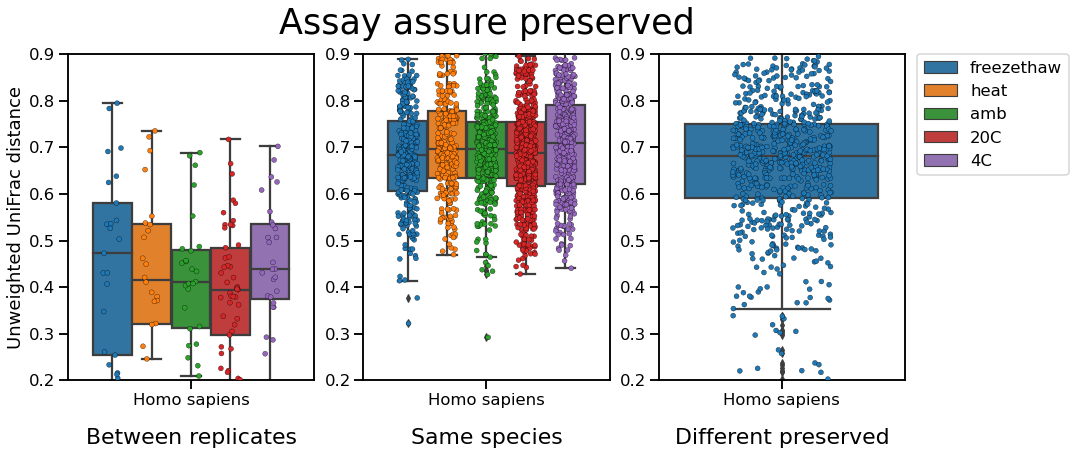

In [59]:
order=["Homo sapiens"]
#palette=['#d95f02','#1b9e77']
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,6))
sns.boxplot(x='host_scientific_name_col1', y='distance', 
            data=dff_etoh_replicates, ax=ax1, 
            hue= variable_1 + '_col1', order = order)
sns.stripplot(x='host_scientific_name_col1', y='distance', 
              data=dff_etoh_replicates, ax=ax1, 
              size=5, hue = variable_1 + '_col1', 
              dodge=True, jitter= 0.2,
              linewidth=0.3, edgecolor='black', order = order)

sns.boxplot(x='host_scientific_name_col1', y='distance', 
            data=dff_etoh_same_spp, ax=ax2, 
            hue= variable_1 + '_col1', order = order)
sns.stripplot(x='host_scientific_name_col1', y='distance', 
              data=dff_etoh_same_spp, ax=ax2, 
              size=5, hue = variable_1 + '_col1', 
              dodge=True, jitter= 0.2,
              linewidth=0.3, edgecolor='black', order = order)

sns.boxplot(x='host_scientific_name_col1', y='distance', 
            data=dff_etoh_diff_spp, ax=ax3, 
            hue= variable_1 + '_col1', order = order)
sns.stripplot(x='host_scientific_name_col1', y='distance', 
              data=dff_etoh_diff_spp, ax=ax3, 
              size=5, hue = variable_1 + '_col1', 
              dodge=True, jitter= 0.2,
              linewidth=0.3, edgecolor='black', order = order)

# adjust the details
ax1.set_xticklabels(ax1.get_xticklabels())
ax2.set_xticklabels(ax2.get_xticklabels())
ax1.set_xlabel('Between replicates', size= 22, labelpad = 20)
ax2.set_xlabel('Same species', size= 22, labelpad = 20)
ax3.set_xlabel('Different preserved', size= 22, labelpad = 20)
ax1.set_ylabel('Unweighted UniFrac distance')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax2.set_title('Assay assure preserved', size = 35, pad = 20)
ax1.set_ylim(0.2,0.9)
ax2.set_ylim(0.2,0.9)
ax3.set_ylim(0.2,0.9)
sns.set_context('talk')
# just show colors in legend
handles, labels = ax1.get_legend_handles_labels()
ax1.get_legend().remove()
ax2.get_legend().remove()
plt.legend(handles[0:5], labels[0:5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Subset distances for isopropanol stored samples

In [60]:
# #subset out pairwise distance between samples collected in isopropanol
# dff_iso = dff[(dff['storage_solution_col1'] == 'isopropanol') & 
#               (dff['storage_solution_col2'] == 'isopropanol') ]

# # subset distances between technical replicates
# dff_iso_replicates = dff_iso[(dff_iso['host_scientific_name_col1'] == dff_iso['host_scientific_name_col2']) & 
#                     (dff_iso['buffer_removal_col1'] == dff_iso['buffer_removal_col2']) &
#                     (dff_iso['protocol_col1'] == dff_iso['protocol_col2']) &
#                     (dff_iso['buffer_removal_col1'] == dff_iso['buffer_removal_col2']) &
#                     (dff_iso['sample_technical_replicate_col1'] != dff_iso['sample_technical_replicate_col2']) &
#                     (dff_iso['host_subject_id_col1'] == dff_iso['host_subject_id_col2'])]

# # subset distances between same host species
# dff_iso_same_spp = dff_iso[(dff_iso['host_scientific_name_col1'] == dff_iso['host_scientific_name_col2']) & 
#                     (dff_iso['buffer_removal_col1'] == dff_iso['buffer_removal_col2']) &
#                     (dff_iso['protocol_col1'] == dff_iso['protocol_col2']) &
#                     (dff_iso['buffer_removal_col1'] == dff_iso['buffer_removal_col2']) &
#                     (dff_iso['host_subject_id_col1'] != dff_iso['host_subject_id_col2'])]

# # subset distances between different host species
# dff_iso_diff_spp = dff_iso[(dff_iso['host_scientific_name_col1'] != dff_iso['host_scientific_name_col2']) & 
#                     (dff_iso['buffer_removal_col1'] == dff_iso['buffer_removal_col2']) &
#                     (dff_iso['protocol_col1'] == dff_iso['protocol_col2']) &
#                     (dff_iso['buffer_removal_col1'] == dff_iso['buffer_removal_col2'])]

In [ ]:
# order=["Homo sapiens", "Mus musculus"]
# #palette=['#d95f02','#1b9e77']
# fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,6))
# sns.boxplot(x='host_scientific_name_col1', y='distance', 
#             data=dff_iso_replicates, ax=ax1, 
#             hue= 'protocol_col1', order = order)
# sns.stripplot(x='host_scientific_name_col1', y='distance', 
#               data=dff_iso_replicates, ax=ax1, 
#               size=5, hue = 'protocol_col1', 
#               dodge=True, jitter= 0.2,
#               linewidth=0.3, edgecolor='black', order = order)

# sns.boxplot(x='host_scientific_name_col1', y='distance', 
#             data=dff_iso_same_spp, ax=ax2, 
#             hue= 'protocol_col1', order = order)
# sns.stripplot(x='host_scientific_name_col1', y='distance', 
#               data=dff_iso_same_spp, ax=ax2, 
#               size=5, hue = 'protocol_col1', 
#               dodge=True, jitter= 0.2,
#               linewidth=0.3, edgecolor='black', order = order)

# sns.boxplot(x='host_scientific_name_col1', y='distance', 
#             data=dff_iso_diff_spp, ax=ax3, 
#             hue= 'protocol_col1', order = order)
# sns.stripplot(x='host_scientific_name_col1', y='distance', 
#               data=dff_iso_diff_spp, ax=ax3, 
#               size=5, hue = 'protocol_col1', 
#               dodge=True, jitter= 0.2,
#               linewidth=0.3, edgecolor='black', order = order)

# # adjust the details
# ax1.set_xticklabels(ax1.get_xticklabels())
# ax2.set_xticklabels(ax2.get_xticklabels())
# ax1.set_xlabel('Between replicates', size= 22, labelpad = 20)
# ax2.set_xlabel('Same species', size= 22, labelpad = 20)
# ax3.set_xlabel('Different species', size= 22, labelpad = 20)
# ax1.set_ylabel('Unweighted UniFrac distance')
# ax2.set_ylabel('')
# ax3.set_ylabel('')
# ax2.set_title('Isopropanol preserved', size = 35, pad = 20)
# ax1.set_ylim(0.2,0.9)
# ax2.set_ylim(0.2,0.9)
# ax3.set_ylim(0.2,0.9)
# sns.set_context('talk')
# # just show colors in legend
# handles, labels = ax1.get_legend_handles_labels()
# ax1.get_legend().remove()
# ax2.get_legend().remove()
# plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Convex Hull

In [ ]:
# utils
import scipy
import glob
import skbio
import qiime2
import itertools
import numpy as np 
import pandas as pd
import scipy.stats as ss
from qiime2.plugins import diversity, feature_table

from skbio import OrdinationResults
from scipy.spatial import ConvexHull
# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex

plt.style.use('ggplot')
%matplotlib inline

The relevant columns would be:

* **storage_solution** (samples collected into EtOH or isopropanol)
* **buffer_removal** (we draw the storage solution supernatant prior to extraction for metabolomics, and the leftovers are either left in the tube, "residue", or dried up in the speedvac, "dry")
* **protocol** ("MMU" is the standard MagMax protocol, and then we have "matrix_600" and "matrix_400", in which we add either 600µL or 400µL of lysis buffer, as we wouldn't be able to fit the full 800µL of lysis buffer into the matrix tubes)


In [ ]:
# import all the data
metadata = pd.read_csv(meta_file, dtype=str, sep='\t', index_col=0)
metadata.index = metadata.index.astype(str)
metadata.index = [x[:15] for x in metadata.index]
ordinations = {x.split('/')[-1].split('.')[0].replace('_biplot','').replace('_',' '):
               qiime2.Artifact.load(x).view(OrdinationResults)
               for x in glob.glob('output/*pcoa.qza')}
ordinations.keys()


# within species

In [ ]:
ndims = 3
results_ch = []
for method_, pc_ord in ordinations.items():
    for protocol_, protcol_sub_df in metadata.groupby(['storage_solution','buffer_removal','protocol']):
        for sp_protocol_, sp_protocol_df in protcol_sub_df.groupby('host_scientific_name'):
            coords = pc_ord.samples.loc[sp_protocol_df.index].dropna().values[:, :ndims]
            print(coords)
            try:
                ch = ConvexHull(coords)
                results_ch.append([method_] + list(protocol_) + ['/'.join(list(protocol_)).replace('_','-'), 
                                                                 sp_protocol_, ch.volume, ch.area])
            except:
                print('???')

results_ch_df = pd.DataFrame(results_ch, columns=['metric','storage_solution','buffer_removal',
                                                  'protocol', 'protocol-merged','host', 'volume', 'area'])
results_ch_df.to_csv('output/t/results/within-species/convex-hull-results.csv')
results_ch_df.head(5)
            

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

anovas = {}
for metric_, mdf in results_ch_df.groupby('metric'):
    for y_ in ['area', 'volume']: 
        moore_lm = ols('%s ~ storage_solution * buffer_removal * protocol' % (y_), data=mdf).fit()
        table = sm.stats.anova_lm(moore_lm, typ=2)
        anovas[(metric_, y_)] = table

anovas = pd.concat(anovas)
anovas.to_csv('output/t/results/within-species/anova-convex-hull-results.csv')
anovas


In [ ]:
    
for x_ in ['storage_solution','buffer_removal','protocol', 'protocol-merged']:
    for y_ in ['area', 'volume']:

        fig, axn = plt.subplots(1,3,figsize=(30, 8))

        for ax, (k_, df_plot) in zip(axn, results_ch_df.groupby('metric')):

            order_ = df_plot.groupby(x_).mean().sort_values(y_).index

            sns.boxplot(x=x_, y=y_, palette='RdBu_r',
                        data=df_plot, order=order_, ax=ax)

            ax.set_title(k_,
                         fontsize=22,
                         weight='bold', y=1.01)

            ax.set_ylabel('Convex Hull (%s)' % (y_),
                          weight='bold',
                          fontsize=22,
                          color='black') 
            ax.set_xlabel('')

            ax.set_facecolor('white')
            ax.set_axisbelow(True)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(True)
            ax.spines['bottom'].set_visible(True)
            ax.spines['top'].set_visible(False)
            for axis in ['bottom','left']:
                  ax.spines[axis].set_linewidth(4)
            for child in ax.get_children():
                if isinstance(child, matplotlib.spines.Spine):
                    child.set_color('black')
            ax.tick_params(axis='y', colors='black', width=4, length=10)
            ax.tick_params(axis='x', colors='black', width=4, length=10)
            ax.set_xticklabels(ax.get_xticklabels(),
                               rotation=45,
                               weight='bold',
                               horizontalalignment='right',
                               rotation_mode="anchor")
            for tick in ax.get_xticklabels():
                tick.set_fontproperties('arial')
                tick.set_ha("right")
                tick.set_weight("bold")
                tick.set_color("black")
                tick.set_fontsize(22)
            for tick in ax.get_yticklabels():
                tick.set_fontproperties('arial')
                tick.set_weight("bold")
                tick.set_color("black")
                tick.set_fontsize(22)

        plt.tight_layout()
        plt.suptitle('%s within species (human or mouse) and between protocols' % (y_),
                     y=1.1,
                     weight='bold',
                          fontsize=22,
                          color='black')

        plt.savefig('output/t/results/within-species/ch-%s-%s.pdf' % (x_, y_),dpi=1000, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')


        plt.show()



# within subjects

In [ ]:
ndims = 3
results_ch = []
for method_, pc_ord in ordinations.items():
    for protocol_, protcol_sub_df in metadata.groupby(['buffer_removal','protocol']):
        for sp_protocol_, sp_protocol_df in protcol_sub_df.groupby('host_subject_id'):
            try:
                coords = pc_ord.samples.loc[sp_protocol_df.index].dropna().values[:, :ndims]

                if coords.shape[0] < 4:
                    continue
                try:
                    ch = ConvexHull(coords)
                except:
                    continue
                results_ch.append([method_] + list(protocol_) + ['/'.join(list(protocol_)).replace('_','-'), 
                                                                 sp_protocol_, ch.volume, ch.area])
            except:
                print('???')

results_ch_df = pd.DataFrame(results_ch, columns=['metric','buffer_removal',
                                                  'protocol', 'protocol-merged',
                                                  'host', 'volume', 'area'])
results_ch_df.to_csv('output/t/results/within-subject/convex-hull-results.csv')
results_ch_df.head(5)

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

anovas = {}
for metric_, mdf in results_ch_df.groupby('metric'):
    for y_ in ['area', 'volume']: 
        moore_lm = ols('%s ~ buffer_removal * protocol' % (y_), data=mdf).fit()
        table = sm.stats.anova_lm(moore_lm, typ=2)
        anovas[(metric_, y_)] = table

anovas = pd.concat(anovas)
anovas.to_csv('output/t/results/within-subject/anova-convex-hull-results.csv')
anovas

In [ ]:
    
for x_ in ['buffer_removal', 'protocol', 'protocol-merged']:
    for y_ in ['area', 'volume']:

        fig, axn = plt.subplots(1,3,figsize=(30, 8))

        for ax, (k_, df_plot) in zip(axn, results_ch_df.groupby('metric')):

            order_ = df_plot.groupby(x_).mean().sort_values(y_).index

            sns.boxplot(x=x_, y=y_, palette='RdBu_r',
                        data=df_plot, order=order_, ax=ax)

            ax.set_title(k_,
                         fontsize=22,
                         weight='bold', y=1.01)

            ax.set_ylabel('Convex Hull (%s)' % (y_),
                          weight='bold',
                          fontsize=22,
                          color='black') 
            ax.set_xlabel('')

            ax.set_facecolor('white')
            ax.set_axisbelow(True)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(True)
            ax.spines['bottom'].set_visible(True)
            ax.spines['top'].set_visible(False)
            for axis in ['bottom','left']:
                  ax.spines[axis].set_linewidth(4)
            for child in ax.get_children():
                if isinstance(child, matplotlib.spines.Spine):
                    child.set_color('black')
            ax.tick_params(axis='y', colors='black', width=4, length=10)
            ax.tick_params(axis='x', colors='black', width=4, length=10)
            ax.set_xticklabels(ax.get_xticklabels(),
                               rotation=45,
                               weight='bold',
                               horizontalalignment='right',
                               rotation_mode="anchor")
            for tick in ax.get_xticklabels():
                tick.set_fontproperties('arial')
                tick.set_ha("right")
                tick.set_weight("bold")
                tick.set_color("black")
                tick.set_fontsize(22)
            for tick in ax.get_yticklabels():
                tick.set_fontproperties('arial')
                tick.set_weight("bold")
                tick.set_color("black")
                tick.set_fontsize(22)

        plt.tight_layout()
        plt.suptitle('%s within subject (between replicates) and between protocols' % (y_),
                     y=1.1,
                     weight='bold',
                          fontsize=22,
                          color='black')

        plt.savefig('output/t/results/within-subject/ch-%s-%s.pdf' % (x_, y_),dpi=1000, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')


        plt.show()
